In [1]:
#https://community.kobotoolbox.org/t/connecting-kobo-form-with-arcgis-online-with-real-time-updates/56724/2
# import requirements 
import requests
import re
import pandas as pd
import geopandas as gpd
from IPython.display import display
from arcgis.gis import GIS
import os
import numpy as np
import zipfile
%matplotlib inline

In [2]:
#Read this
#https://support.kobotoolbox.org/synchronous_exports.html

#FETCH KOBO DATA

# Authentication credentials
username = "guilherme_iablonovski"
password = "k0b0Senha"

# API endpoint and export token
#https://kf.kobotoolbox.org/api/v2/assets/ayiVZpWqjmFSTdoncb6qVY/export-settings/esgskDVDcS8UsPJBHbC3Ntp/data.xlsx
kobo_api_url = "https://kf.kobotoolbox.org/api/v2/assets/ayiVZpWqjmFSTdoncb6qVY/export-settings/esgskDVDcS8UsPJBHbC3Ntp"
kobo_api_url_mng = "https://kf.kobotoolbox.org/api/v2/assets/abXLDGKnRvqrz7rxm923a5/export-settings/esp4KdirwunKWc9ByAJxxHY"

export_token = "f72722c6ffe97db14144325853528a4b7a1c059b"

def getKoboForm(url):
    # Create a session with authentication
    session = requests.Session()
    session.auth = (username, password)

    # Construct the export URL
    kobo_export_url = f"{url}/data.xlsx"#?format=csv&token={export_token}"

    # Fetch data using the authenticated session
    response = session.get(kobo_export_url)

    # Check if the request was successful
    if response.status_code == 200:
        # Load data into a pandas DataFrame
        kobo_data = pd.read_excel(response.content)
        kobo_data.head()
        return kobo_data
    else:
        print("Error:", response.status_code)
        
kobo_data = getKoboForm(kobo_api_url)
kobo_mng_data = getKoboForm(kobo_api_url_mng)

/var/folders/x9/qv8lxrjd7cvd4ntlg3mqwjw80000gn/T/ipykernel_7873/3160951712.py:31: FutureWarning: Passing bytes to 'read_excel' is deprecated and will be removed in a future version. To read from a byte string, wrap it in a `BytesIO` object.
  kobo_data = pd.read_excel(response.content)
/var/folders/x9/qv8lxrjd7cvd4ntlg3mqwjw80000gn/T/ipykernel_7873/3160951712.py:31: FutureWarning: Passing bytes to 'read_excel' is deprecated and will be removed in a future version. To read from a byte string, wrap it in a `BytesIO` object.
  kobo_data = pd.read_excel(response.content)


In [3]:
kobo_mng_data

,Your name,Your email,Implementing agency name,"If other, please specify",Contractor's name,No. of CfW beneficiaries employed (if applicable) during reporting period,No. of days worked by CfW beneficiaries,Proportion of women CfW [%],Site location,Please specify the municipality (Deir Al-Balah),...,_Debris disposal site location_precision,Total debris disposed during the reporting period,Measurement unit.4,Was asbestos contaminated debris accepted to site for disposal?,Was the asbestos contaminated debris disposed in a dedicated hazardous waste cell?,Amount of asbestos contaminated debris disposed,Measurement unit.5,Was any Explosive Ordnance identified in the debris that was disposed?,_id,_uuid
0,Mohammed Mezyad,mohammad.mezyad@undp.org,UNDP,NaN,1-El khaesie Company Eastward 2-Palestinian Co...,33,12,0,Deir Al-Balah Khan Younis,Deir al Balah,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,554867668,f17de59f-a4a6-4f80-bafe-d13445b3cf49


In [4]:
#To-do in Kobo:
#ADD Deir Al-Balah Camp to Kobo

In [6]:
kobo_mng_data.replace(np.NaN,0)

,Your name,Your email,Implementing agency name,"If other, please specify",Contractor's name,No. of CfW beneficiaries employed (if applicable) during reporting period,No. of days worked by CfW beneficiaries,Proportion of women CfW [%],Site location,Please specify the municipality (Deir Al-Balah),...,_Debris disposal site location_precision,Total debris disposed during the reporting period,Measurement unit.4,Was asbestos contaminated debris accepted to site for disposal?,Was the asbestos contaminated debris disposed in a dedicated hazardous waste cell?,Amount of asbestos contaminated debris disposed,Measurement unit.5,Was any Explosive Ordnance identified in the debris that was disposed?,_id,_uuid
0,Mohammed Mezyad,mohammad.mezyad@undp.org,UNDP,0.0,1-El khaesie Company Eastward 2-Palestinian Co...,33,12,0,Deir Al-Balah Khan Younis,Deir al Balah,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,554867668,f17de59f-a4a6-4f80-bafe-d13445b3cf49


In [7]:
#Standardize data for municipalities without neighborhoods

def standardize(df):

    kobo_data_0 = df.replace(0, None)
    kobo_data_0.columns = kobo_data_0.columns.str.replace('Please specify the neighbourhood', '').str.strip()


    #Create fields for the municipalities that don't have follow-up neighborhood questions

    kobo_data_0['(Deir Al-Balah / Al Maghazi)'] = None
    kobo_data_0.loc[kobo_data_0['Please specify the municipality (Deir Al-Balah)'].astype(str).str.contains('Al Maghazi'), 
           '(Deir Al-Balah / Al Maghazi)'] = 'Al Maghazi Camp'


    kobo_data_0['(Deir Al-Balah / Al Qarara)'] = None
    kobo_data_0.loc[kobo_data_0['Please specify the municipality (Deir Al-Balah)'].astype(str).str.contains('Al Qarara'), 
           '(Deir Al-Balah / Al Qarara)'] = 'Smeiri'

    kobo_data_0['(Gaza / Al Bureij)'] = None
    kobo_data_0.loc[kobo_data_0['Please specify the municipality (Gaza)'].astype(str).str.contains('Al Bureij'), 
           '(Gaza / Al Bureij)'] = 'Al Bureij'

    kobo_data_0['(Khan Younis / Al-Nnaser (Al Bayuk)'] = None
    kobo_data_0.loc[
        kobo_data_0['Please specify the municipality (Khan Younis)'].astype(str).str.contains('Al-Nnaser \(Al Bayuk\)', case=False, na=False),
        '(Khan Younis / Al-Nnaser (Al Bayuk))'
    ] = 'Umm Kameil'

    kobo_data_0['(North Gaza / Um Al-NASER)'] = None
    kobo_data_0.loc[
        kobo_data_0['Please specify the municipality (North Gaza)'].astype(str).str.contains('Um Al-NASER', case=False, na=False),
        '(North Gaza / Um Al-NASER)'
    ] = 'Al Qaraya al Badawiya al Maslakh'


    kobo_data_0['(Rafah / Al-Nnaser (Al Bayuk))'] = None
    kobo_data_0.loc[
        kobo_data_0['Please specify the municipality (Rafah)'].astype(str).str.contains('Al-Nnaser \(Al Bayuk\)', case=False, na=False),
        '(Rafah / Al-Nnaser (Al Bayuk))'
    ] = 'An Nasr'
    
    return kobo_data_0

kobo_data = standardize(kobo_data)
kobo_data_mng = standardize(kobo_mng_data)

In [8]:
kobo_data_mng.dropna(axis=1, how='all').columns

Index(['Your name', 'Your email', 'Implementing agency name',
       'Contractor's name',
       'No. of CfW beneficiaries employed (if applicable) during reporting period',
       'No. of days worked by CfW beneficiaries', 'Site location',
       'Please specify the municipality (Deir Al-Balah)',
       'Please specify the municipality (Khan Younis)',
       '(Deir Al-Balah / Deir al Balah)', '(Khan Younis / Khan Yunis)',
       'Start date', 'End date', 'Was asbestos present in the debris?',
       'Was any Explosive Ordnance identified in the debris?',
       'Have human remains been found in the debris?',
       'Any other hazards identified in the debris?', '_id', '_uuid',
       '(Khan Younis / Al-Nnaser (Al Bayuk))'],
      dtype='object')

In [14]:
def removeColumns(df):

    kobo_data_filter_NA = df.dropna(axis=1, how='all')
    print(kobo_data_filter_NA.columns)

    for coluna in kobo_data_filter_NA.columns:
        if coluna.startswith('('):  # Verifica se a coluna começa com '('
            kobo_data_filter_NA[coluna] = kobo_data_filter_NA[coluna].where(
                kobo_data_filter_NA[coluna].isna(),  # Condição: mantém onde é NaN
                coluna + "_" + kobo_data_filter_NA[coluna].astype(str)  # Substitui o resto
            )

    # Lista das colunas que começam com 'Location' ou 'Please'
    colunas_para_remover = [
        col for col in kobo_data_filter_NA.columns 
        if col.startswith(('Location', 'Please'))
    ]

    print("Preparing to remove "+ str(colunas_para_remover))

    # Remove as colunas do DataFrame
    kobo_data_filter_NA = kobo_data_filter_NA.drop(columns=colunas_para_remover)
    print(kobo_data_filter_NA.columns)

    cols_para_destrinchar = [col for col in kobo_data_filter_NA.columns if str(kobo_data_filter_NA[col].iloc[0]).startswith('(')]

    new_df = pd.DataFrame(columns=kobo_data_filter_NA.columns)



    for _, row in kobo_data_filter_NA.iterrows():
        # Verificamos se a linha contém valores que começam com '(' nas colunas selecionadas
        if any(str(row[col]).startswith('(') for col in cols_para_destrinchar):
            # Para cada coluna que começa com '(', criamos uma nova linha
            for col in cols_para_destrinchar:
                if str(row[col]).startswith('('):
                    nova_linha = row.copy()
                    # Mantemos apenas a coluna atual preenchida, as outras ficam nulas
                    for other_col in cols_para_destrinchar:
                        if other_col != col:
                            nova_linha[other_col] = np.nan
                    new_df = pd.concat([new_df, pd.DataFrame([nova_linha])], ignore_index=True)
        else:
            # Se a linha não tem valores que começam com '(', apenas adicionamos ao novo DataFrame
            new_df = pd.concat([new_df, pd.DataFrame([row])], ignore_index=True)

    new_df.reset_index(drop=True, inplace=True)
    return new_df

novo_df = removeColumns(kobo_data)
print(kobo_data_mng.columns)
novo_df_mng = removeColumns(kobo_data_mng)

Index(['Your name', 'Your email', 'Implementing agency name',
       'Location of planned intervention(s)',
       'Please specify the municipality (Deir Al-Balah)',
       'Please specify the municipality (Khan Younis)',
       'Please specify the municipality (Rafah)',
       '(Deir Al-Balah / Deir al Balah)', '(Khan Younis / Khan Yunis)',
       '(Rafah / Rafah)', 'Total debris removal target', 'Measurement unit',
       'Total debris recycled target', 'Measurement unit.1',
       'Expected start date', 'Expected end date', '_id', '_uuid',
       '(Khan Younis / Al-Nnaser (Al Bayuk))'],
      dtype='object')
Preparing to remove ['Location of planned intervention(s)', 'Please specify the municipality (Deir Al-Balah)', 'Please specify the municipality (Khan Younis)', 'Please specify the municipality (Rafah)']
Index(['Your name', 'Your email', 'Implementing agency name',
       '(Deir Al-Balah / Deir al Balah)', '(Khan Younis / Khan Yunis)',
       '(Rafah / Rafah)', 'Total debris remo

/var/folders/x9/qv8lxrjd7cvd4ntlg3mqwjw80000gn/T/ipykernel_7873/3362582868.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kobo_data_filter_NA[coluna] = kobo_data_filter_NA[coluna].where(
/var/folders/x9/qv8lxrjd7cvd4ntlg3mqwjw80000gn/T/ipykernel_7873/3362582868.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kobo_data_filter_NA[coluna] = kobo_data_filter_NA[coluna].where(
/var/folders/x9/qv8lxrjd7cvd4ntlg3mqwjw80000gn/T/ipykernel_7873/3362582868.py:8: SettingWithCopyWarning: 
A value is trying to b

In [15]:
novo_df_mng.columns

Index(['Your name', 'Your email', 'Implementing agency name',
       'Contractor's name',
       'No. of CfW beneficiaries employed (if applicable) during reporting period',
       'No. of days worked by CfW beneficiaries', 'Site location',
       '(Deir Al-Balah / Deir al Balah)', '(Khan Younis / Khan Yunis)',
       'Start date', 'End date', 'Was asbestos present in the debris?',
       'Was any Explosive Ordnance identified in the debris?',
       'Have human remains been found in the debris?',
       'Any other hazards identified in the debris?', '_id', '_uuid',
       '(Khan Younis / Al-Nnaser (Al Bayuk))'],
      dtype='object')

In [16]:
# Reload the just-uploaded neighborhood mapping file
neigh_map = pd.read_csv("Caminho bairros - Página3.csv")

# Clean and extract all valid neighborhoods
neigh_map[['Governorate', 'Municipality']] = neigh_map[['Governorate', 'Municipality']].fillna(method='ffill')
valid_neighborhoods = neigh_map['Neighborhood'].dropna().unique().tolist()
valid_neigh_lower = [n.lower().strip() for n in valid_neighborhoods]

/var/folders/x9/qv8lxrjd7cvd4ntlg3mqwjw80000gn/T/ipykernel_7873/2993670551.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  neigh_map[['Governorate', 'Municipality']] = neigh_map[['Governorate', 'Municipality']].fillna(method='ffill')


In [17]:
neigh_map[neigh_map['Municipality']=='Al Maghazi']

,Governorate,Municipality,Neighborhood,Obs
2,Deir Al-Balah,Al Maghazi,NaN,NaN


In [18]:
def explode(df):

    # Identify all (Governorate / Municipality) columns
    location_cols = [col for col in df.columns if col.startswith("(")]

    # Updated location extraction function with fallback when neighborhoods aren't matched
    def extract_locations(row):
        locations = []
        for col in location_cols:
            val = row.get(col)
            if pd.isna(val):
                continue
            try:
                gov_mun, neigh_part = val.split('_', 1)
            except ValueError:
                # No neighborhood string at all
                locations.append(col.strip())
                continue

            matched_any = False
            words = neigh_part.strip().split()
            idx = 0
            while idx < len(words):
                for end in range(len(words), idx, -1):
                    candidate = ' '.join(words[idx:end])
                    if candidate.lower().strip() in valid_neigh_lower:
                        locations.append(f'{gov_mun}_{candidate}')
                        idx = end - 1
                        matched_any = True
                        break
                idx += 1

            if not matched_any:
                locations.append(col.strip())  # Fallback if no neighborhood matched
        return locations

    # Apply and explode
    df['location_list'] = df.apply(extract_locations, axis=1)
    df_exploded = df.explode('location_list').rename(columns={'location_list': 'location_1'})
    df_exploded = df_exploded[df_exploded['location_1'].notna() & (df_exploded['location_1'] != '')]
    return df_exploded.reset_index()

df_exploded = explode(novo_df)
df_exploded_mng = explode(novo_df_mng)

In [19]:

df_exploded.location_1

0                            (Rafah / Rafah)_Rafah
1             (Khan Younis / Al-Nnaser (Al Bayuk))
2       (Deir Al-Balah / Deir al Balah)_Ar Rasheed
3    (Deir Al-Balah / Deir al Balah)_Deir al Balah
4            (Deir Al-Balah / Deir al Balah)_Other
5              (Khan Younis / Khan Yunis)_As Sater
6                 (Khan Younis / Khan Yunis)_Hamad
7           (Khan Younis / Khan Yunis)_Khan Younis
8       (Khan Younis / Khan Yunis)_Khan Yunis Camp
9             (Khan Younis / Al-Nnaser (Al Bayuk))
Name: location_1, dtype: object

In [20]:
#Set up the geodataframes and merge then
gaza_neighborhoods = gpd.read_file('UNEP_GazaNeighborhoods_Location_Singleparts.gpkg')

gaza_neighborhoods['location_id'] = (
    '(' + gaza_neighborhoods['Governorate'].astype(str).str.strip() + ' / ' +
    gaza_neighborhoods['Municipality'].astype(str).str.strip() + ')_' +
    gaza_neighborhoods['Neighborhood'].astype(str).str.strip()
)


gaza_cities = gaza_neighborhoods.dissolve(by='Municipality').reset_index()
gaza_cities = gaza_cities[['Municipality','Governorate','geometry']]
gaza_cities['location_id'] = (
    '(' + gaza_cities['Governorate'].astype(str).str.strip() + ' / ' +
    gaza_cities['Municipality'].astype(str).str.strip() + ')'
)
gaza_cities


gaza_neighborhoods = pd.concat([gaza_neighborhoods, gaza_cities])
gaza_neighborhoods

,OBJECTID,Neighborhood,Municipality,Governorate,Shape__Area,Shape__Length,ArabicName,governate_name,municipality_name,neighborhood_name,Location_gdf,geometry,location_id
0,70.0,Al Mashroo,Jabalya,North Gaza,54669.311523,1053.315319,None,north_gaza,jabalya,al_mashroo,(North Gaza / Jabalya)/Al Mashroo,"POLYGON ((3841279.457 3702816.396, 3841300.325...",(North Gaza / Jabalya)_Al Mashroo
1,88.0,Alkhazan,Beit Lahiya,North Gaza,117436.221680,1756.430398,None,north_gaza,beit_lahiya,alkhazan,(North Gaza / Beit Lahiya)/Alkhazan,"POLYGON ((3840336.822 3703797.405, 3840317.682...",(North Gaza / Beit Lahiya)_Alkhazan
2,61.0,Al Fukhkhari,Al Fukhkhari,Khan Younis,230330.200195,2161.057834,None,khan_younis,al_fukhkhari,al_fukhkhari,(Khan Younis / Al Fukhkhari)/Al Fukhkhari,"POLYGON ((3820849.81 3669353.982, 3820826.211 ...",(Khan Younis / Al Fukhkhari)_Al Fukhkhari
3,52.0,Al-Sekka,Beit Hanun,North Gaza,213068.184570,2460.507864,None,north_gaza,beit_hanun,al_sekka,(North Gaza / Beit Hanun)/Al-Sekka,"POLYGON ((3843680.416 3703304.83, 3843616.329 ...",(North Gaza / Beit Hanun)_Al-Sekka
4,51.0,Al-Nazaz,Beit Hanun,North Gaza,338751.844727,2512.213376,None,north_gaza,beit_hanun,al_nazaz,(North Gaza / Beit Hanun)/Al-Nazaz,"POLYGON ((3845273.29 3701417.644, 3845212.544 ...",(North Gaza / Beit Hanun)_Al-Nazaz
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,NaN,NaN,Madinat Ezahra,Gaza,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((3832294.754 3693248.262, 3832278.82 ...",(Gaza / Madinat Ezahra)
20,NaN,NaN,Rafah,Rafah,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((3815835.629 3665959.278, 3815837.514...",(Rafah / Rafah)
21,NaN,NaN,Shokat as Sufi,Rafah,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((3816092.796 3666660.519, 3816109.608...",(Rafah / Shokat as Sufi)
22,NaN,NaN,Um Al-NASER,North Gaza,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((3844411.293 3706209.147, 3844441.48 ...",(North Gaza / Um Al-NASER)


In [21]:
#Merge it to the exploded data
gdf_exploded = gaza_neighborhoods[['location_id','geometry','Neighborhood','Municipality','Governorate']].merge(df_exploded, how='inner', left_on='location_id', right_on='location_1')
gdf_exploded_mng = gaza_neighborhoods[['location_id','geometry','Neighborhood','Municipality','Governorate']].merge(df_exploded_mng, how='inner', left_on='location_id', right_on='location_1')

# Lista das colunas que começam com 'Location' ou 'Please'
colunas_para_remover = [
    col for col in gdf_exploded.columns 
    if col.startswith(('(','location_1'))
]

colunas_para_remover_mng = [
    col for col in gdf_exploded_mng.columns 
    if col.startswith(('(','location_1'))
]


# Remove as colunas do DataFrame
gdf_exploded = gdf_exploded.drop(columns=colunas_para_remover)
gdf_exploded_mng = gdf_exploded_mng.drop(columns=colunas_para_remover_mng)

In [22]:
gdf_exploded_mng

,location_id,geometry,Neighborhood,Municipality,Governorate,index,Your name,Your email,Implementing agency name,Contractor's name,...,No. of days worked by CfW beneficiaries,Site location,Start date,End date,Was asbestos present in the debris?,Was any Explosive Ordnance identified in the debris?,Have human remains been found in the debris?,Any other hazards identified in the debris?,_id,_uuid
0,(Khan Younis / Khan Yunis)_Hamad,"POLYGON ((3820350.738 3681825.956, 3820374.271...",Hamad,Khan Yunis,Khan Younis,1,Mohammed Mezyad,mohammad.mezyad@undp.org,UNDP,1-El khaesie Company Eastward 2-Palestinian Co...,...,12,Deir Al-Balah Khan Younis,2025-09-13,2025-09-28,No,No,No,No,554867668,f17de59f-a4a6-4f80-bafe-d13445b3cf49
1,(Khan Younis / Khan Yunis)_Khan Younis,"POLYGON ((3819629.744 3679302.035, 3819656.496...",Khan Younis,Khan Yunis,Khan Younis,1,Mohammed Mezyad,mohammad.mezyad@undp.org,UNDP,1-El khaesie Company Eastward 2-Palestinian Co...,...,12,Deir Al-Balah Khan Younis,2025-09-13,2025-09-28,No,No,No,No,554867668,f17de59f-a4a6-4f80-bafe-d13445b3cf49
2,(Deir Al-Balah / Deir al Balah)_Deir al Balah,"POLYGON ((3824778.277 3688640.858, 3824772.802...",Deir al Balah,Deir al Balah,Deir Al-Balah,0,Mohammed Mezyad,mohammad.mezyad@undp.org,UNDP,1-El khaesie Company Eastward 2-Palestinian Co...,...,12,Deir Al-Balah Khan Younis,2025-09-13,2025-09-28,No,No,No,No,554867668,f17de59f-a4a6-4f80-bafe-d13445b3cf49


<Axes: >

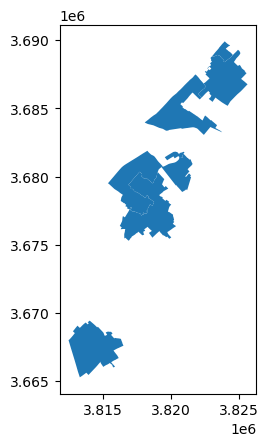

In [23]:
gdf_exploded.plot()

In [24]:
gdf_exploded_mng.columns

Index(['location_id', 'geometry', 'Neighborhood', 'Municipality',
       'Governorate', 'index', 'Your name', 'Your email',
       'Implementing agency name', 'Contractor's name',
       'No. of CfW beneficiaries employed (if applicable) during reporting period',
       'No. of days worked by CfW beneficiaries', 'Site location',
       'Start date', 'End date', 'Was asbestos present in the debris?',
       'Was any Explosive Ordnance identified in the debris?',
       'Have human remains been found in the debris?',
       'Any other hazards identified in the debris?', '_id', '_uuid'],
      dtype='object')

In [25]:
gdf_exploded['Total debris removal target'] = gdf_exploded['Total debris removal target'].astype(float)
gdf_exploded['Total debris recycled target'] = gdf_exploded['Total debris recycled target'].astype(float)

In [26]:
columns_to_float = [
    'No. of CfW beneficiaries employed (if applicable) during reporting period',
    'No. of days worked by CfW beneficiaries',
    'Proportion of women CfW [%]',
    'Total debris removed for recycling',
    'Total debris removed for disposal',
    'What quantity of debris is contaminated with asbestos?',
    '_Debris Recycling Site Location_latitude',
    '_Debris Recycling Site Location_longitude',
    'No. of CfW beneficiaries employed (if applicable) during reporting period.1',
    'No. of days worked by CfW beneficiaries.1',
    'Proportion of women CfW [%].1',
    'Total debris sorted',
    'Total debris recycled',
    '_Debris disposal site location_latitude',
    '_Debris disposal site location_longitude',
    'Total debris disposed during the reporting period'
]

for col in columns_to_float:
    if col in gdf_exploded_mng.columns:
        gdf_exploded_mng[col] = gdf_exploded_mng[col].astype(float)


In [27]:
gdf_exploded_mng['Start date']

0   2025-09-13
1   2025-09-13
2   2025-09-13
Name: Start date, dtype: datetime64[ns]

In [28]:
#Handle columns so they are not modified by arcgis when uploaded
def makeArcGISfriendly(df):
    df.columns = df.columns.str.replace(r"[ ]", "_", regex=True)
    df.columns = df.columns.str.replace(r"[.]", "_", regex=True)
    df.columns = df.columns.str.replace(r"[?]", "_", regex=True)
    df.columns = df.columns.str.replace(r"[']", "", regex=True)
    df.columns = df.columns.str.replace(r"[(]", "", regex=True)
    df.columns = df.columns.str.replace(r"[)]", "", regex=True)
    df.columns = df.columns.str.replace(r"[[]", "", regex=True)
    df.columns = df.columns.str.replace(r"[]]", "", regex=True)
    df.columns = df.columns.str.replace(r"[%]", "_", regex=True)
    df.columns = map(str.lower, df.columns)
    # Remove leading underscores
    df = df.rename(columns={
        '_id':'f_id',
        '_uuid':'f_uuid',
        'expected_start_date':'start_date',
        'expected_end_date':'end_date'
    })
    df.columns = df.columns.str.lstrip('_')
    #Truncate and ensure uniqueness
    seen = {}
    final_cols = []
    max_length = 31
    for col in df.columns:
        base = col[:max_length]
        new_col = base
        i = 1
        while new_col in seen:
            suffix = f"_{i}"
            trim_len = max_length - len(suffix)
            new_col = base[:trim_len] + suffix
            i += 1
        seen[new_col] = True
        final_cols.append(new_col)
    
    # Step 4: Apply to DataFrame
    df.columns = final_cols
    return df

gdf_exploded = makeArcGISfriendly(gdf_exploded)
gdf_exploded_mng = makeArcGISfriendly(gdf_exploded_mng)

/Users/guilhermeiablonovski/opt/anaconda3/envs/arcgisenv/lib/python3.10/site-packages/pandas/core/strings/object_array.py:172: FutureWarning: Possible nested set at position 1
  pat = re.compile(pat, flags=flags)


In [29]:
gdf_exploded_mng.columns

Index(['location_id', 'geometry', 'neighborhood', 'municipality',
       'governorate', 'index', 'your_name', 'your_email',
       'implementing_agency_name', 'contractors_name',
       'no__of_cfw_beneficiaries_employ', 'no__of_days_worked_by_cfw_benef',
       'site_location', 'start_date', 'end_date',
       'was_asbestos_present_in_the_deb', 'was_any_explosive_ordnance_iden',
       'have_human_remains_been_found_i', 'any_other_hazards_identified_in',
       'f_id', 'f_uuid'],
      dtype='object')

In [30]:
def simplifyGeometries(df):
    df['geometry'] = df['geometry'].centroid
    return df
    
gdf_exploded = simplifyGeometries(gdf_exploded)
gdf_exploded_mng = simplifyGeometries(gdf_exploded_mng)

In [31]:
gdf_exploded.columns

Index(['location_id', 'geometry', 'neighborhood', 'municipality',
       'governorate', 'index', 'your_name', 'your_email',
       'implementing_agency_name', 'total_debris_removal_target',
       'measurement_unit', 'total_debris_recycled_target',
       'measurement_unit_1', 'start_date', 'end_date', 'f_id', 'f_uuid'],
      dtype='object')

In [32]:
gdf_exploded_mng.columns

Index(['location_id', 'geometry', 'neighborhood', 'municipality',
       'governorate', 'index', 'your_name', 'your_email',
       'implementing_agency_name', 'contractors_name',
       'no__of_cfw_beneficiaries_employ', 'no__of_days_worked_by_cfw_benef',
       'site_location', 'start_date', 'end_date',
       'was_asbestos_present_in_the_deb', 'was_any_explosive_ordnance_iden',
       'have_human_remains_been_found_i', 'any_other_hazards_identified_in',
       'f_id', 'f_uuid'],
      dtype='object')

In [33]:
gdf_exploded.columns.intersection(gdf_exploded_mng.columns)

Index(['location_id', 'geometry', 'neighborhood', 'municipality',
       'governorate', 'index', 'your_name', 'your_email',
       'implementing_agency_name', 'start_date', 'end_date', 'f_id', 'f_uuid'],
      dtype='object')

In [34]:
gdf_exploded_mng

,location_id,geometry,neighborhood,municipality,governorate,index,your_name,your_email,implementing_agency_name,contractors_name,...,no__of_days_worked_by_cfw_benef,site_location,start_date,end_date,was_asbestos_present_in_the_deb,was_any_explosive_ordnance_iden,have_human_remains_been_found_i,any_other_hazards_identified_in,f_id,f_uuid
0,(Khan Younis / Khan Yunis)_Hamad,POINT (3820268.559 3681556.55),Hamad,Khan Yunis,Khan Younis,1,Mohammed Mezyad,mohammad.mezyad@undp.org,UNDP,1-El khaesie Company Eastward 2-Palestinian Co...,...,12.0,Deir Al-Balah Khan Younis,2025-09-13,2025-09-28,No,No,No,No,554867668,f17de59f-a4a6-4f80-bafe-d13445b3cf49
1,(Khan Younis / Khan Yunis)_Khan Younis,POINT (3818413.206 3677564.237),Khan Younis,Khan Yunis,Khan Younis,1,Mohammed Mezyad,mohammad.mezyad@undp.org,UNDP,1-El khaesie Company Eastward 2-Palestinian Co...,...,12.0,Deir Al-Balah Khan Younis,2025-09-13,2025-09-28,No,No,No,No,554867668,f17de59f-a4a6-4f80-bafe-d13445b3cf49
2,(Deir Al-Balah / Deir al Balah)_Deir al Balah,POINT (3823919.061 3687127.03),Deir al Balah,Deir al Balah,Deir Al-Balah,0,Mohammed Mezyad,mohammad.mezyad@undp.org,UNDP,1-El khaesie Company Eastward 2-Palestinian Co...,...,12.0,Deir Al-Balah Khan Younis,2025-09-13,2025-09-28,No,No,No,No,554867668,f17de59f-a4a6-4f80-bafe-d13445b3cf49


In [35]:
df1 = gdf_exploded
df1['form'] = 'Planned'

if 'total_debris_removal_target' in df1.columns:
    df1['total_debris'] = df1['total_debris_removal_target']
else:
    df1['total_debris'] = 0

df2 = gdf_exploded_mng
df2['form'] = 'Carried through'

# Only sum columns that exist
total_cols = []
if 'total_debris_removed_for_dispos' in df2.columns:
    total_cols.append('total_debris_removed_for_dispos')
if 'total_debris_removed_for_recycl' in df2.columns:
    total_cols.append('total_debris_removed_for_recycl')

if total_cols:
    df2['total_debris'] = df2[total_cols].sum(axis=1)
else:
    df2['total_debris'] = 0


gdf_master = gpd.GeoDataFrame(pd.concat([df1,df2]), geometry='geometry').reset_index().drop(columns=['level_0','index'])

In [36]:
seen = set()
unique_flags = []

for _, row in gdf_master.iterrows():
    if row['f_id'] in seen:
        unique_flags.append('')
    else:
        unique_flags.append('yes')
        seen.add(row['f_id'])

gdf_master['unique_'] = unique_flags
gdf_master

,location_id,geometry,neighborhood,municipality,governorate,your_name,your_email,implementing_agency_name,total_debris_removal_target,measurement_unit,...,total_debris,contractors_name,no__of_cfw_beneficiaries_employ,no__of_days_worked_by_cfw_benef,site_location,was_asbestos_present_in_the_deb,was_any_explosive_ordnance_iden,have_human_remains_been_found_i,any_other_hazards_identified_in,unique_
0,(Khan Younis / Khan Yunis)_Hamad,POINT (3820268.559 3681556.55),Hamad,Khan Yunis,Khan Younis,Mohammed Mezyad,mohammad.mezyad@undp.org,UNDP,31273.0,Metric tonnes (t),...,31273.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes
1,(Deir Al-Balah / Deir al Balah)_Ar Rasheed,POINT (3823871.017 3689117.778),Ar Rasheed,Deir al Balah,Deir Al-Balah,Mohammed Mezyad,mohammad.mezyad@undp.org,UNDP,31273.0,Metric tonnes (t),...,31273.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
2,(Deir Al-Balah / Deir al Balah)_Other,POINT (3820829.743 3684809.621),Other,Deir al Balah,Deir Al-Balah,Mohammed Mezyad,mohammad.mezyad@undp.org,UNDP,31273.0,Metric tonnes (t),...,31273.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
3,(Rafah / Rafah)_Rafah,POINT (3814291.86 3667436.747),Rafah,Rafah,Rafah,Ahmad,mm@gmail.com,Other,200.0,Metric tonnes (t),...,200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes
4,(Khan Younis / Khan Yunis)_Khan Yunis Camp,POINT (3817451.766 3679639.191),Khan Yunis Camp,Khan Yunis,Khan Younis,Mohammed Mezyad,mohammad.mezyad@undp.org,UNDP,31273.0,Metric tonnes (t),...,31273.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
5,(Khan Younis / Khan Yunis)_Khan Younis,POINT (3818413.206 3677564.237),Khan Younis,Khan Yunis,Khan Younis,Mohammed Mezyad,mohammad.mezyad@undp.org,UNDP,31273.0,Metric tonnes (t),...,31273.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
6,(Khan Younis / Khan Yunis)_As Sater,POINT (3820646.401 3680296.392),As Sater,Khan Yunis,Khan Younis,Mohammed Mezyad,mohammad.mezyad@undp.org,UNDP,31273.0,Metric tonnes (t),...,31273.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
7,(Deir Al-Balah / Deir al Balah)_Deir al Balah,POINT (3823919.061 3687127.03),Deir al Balah,Deir al Balah,Deir Al-Balah,Mohammed Mezyad,mohammad.mezyad@undp.org,UNDP,31273.0,Metric tonnes (t),...,31273.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
8,(Khan Younis / Khan Yunis)_Hamad,POINT (3820268.559 3681556.55),Hamad,Khan Yunis,Khan Younis,Mohammed Mezyad,mohammad.mezyad@undp.org,UNDP,NaN,NaN,...,0.0,1-El khaesie Company Eastward 2-Palestinian Co...,33.0,12.0,Deir Al-Balah Khan Younis,No,No,No,No,yes
9,(Khan Younis / Khan Yunis)_Khan Younis,POINT (3818413.206 3677564.237),Khan Younis,Khan Yunis,Khan Younis,Mohammed Mezyad,mohammad.mezyad@undp.org,UNDP,NaN,NaN,...,0.0,1-El khaesie Company Eastward 2-Palestinian Co...,33.0,12.0,Deir Al-Balah Khan Younis,No,No,No,No,


In [37]:
planning_file = 'DWG_Gaza_DebrisPlanningResponses'
management_file = 'DWG_Gaza_DebrisManagementResponses'
master_file = 'DWG_Gaza_DebrisFormsResponses'
#gdf_exploded.to_file(planning_file+'.gpkg')
#gdf_exploded_mng.to_file(management_file+'.gpkg')
gdf_master.to_file(master_file+'.gpkg')

In [38]:
#Connect to the ArcGIS Enterprise portal
gis = GIS('https://wesrmapportal.unep.org/portal/', 'h.partow', 'R&Runit2024')
gis

GIS @ https://wesrmapportal.unep.org/portal/ version:2025.1

In [31]:
# Access the feature-layer through its URL
planning_file = 'DWG_Gaza_DebrisPlanningResponses'
management_file = 'DWG_Gaza_DebrisManagementResponses'
master_file = 'DWG_Gaza_DebrisAllFormsResponses'


def searchArcgis(keyword):
    search_result = gis.content.search("title:"+keyword, item_type = "Feature Layer")
    return search_result

search_planning = searchArcgis(planning_file)
search_management = searchArcgis(management_file)
search_master = searchArcgis(master_file)

display(search_master)
search_master[0]

[<Item title:"DWG_Gaza_DebrisAllFormsResponses" type:Feature Layer Collection owner:h.partow>]

<Item title:"DWG_Gaza_DebrisAllFormsResponses" type:Feature Layer Collection owner:h.partow>

In [32]:
print(search_management[0].type)

Feature Service


In [33]:
import geopandas as gpd
import json
from arcgis.features import FeatureLayerCollection
from arcgis.features import FeatureSet, GeoAccessor
from arcgis.geometry import Geometry

def updateFeature(search_results, exploded_gdf):

    item = gis.content.get(search_results[0].id)

    flc = FeatureLayerCollection.fromitem(item)
    layer = flc.layers[0]  # Assuming you're working with the first layer


    # Step 1: Truncate features
    truncate_result = layer.manager.truncate()
    print("Truncate result:", truncate_result)

    # Keep only matching columns
    expected_fields = [f["name"] for f in layer.properties.fields if f["name"] != "fid"]
    exploded_gdf = exploded_gdf[[col for col in exploded_gdf.columns if col in expected_fields or col == "geometry"]]

    exploded_gdf = exploded_gdf.to_crs(epsg=4326)

    sedf = GeoAccessor.from_geodataframe(exploded_gdf)

    fs = FeatureSet.from_dataframe(sedf)

    result = layer.edit_features(adds=fs.features)
    print("Result:", result)
    return(result)

updateFeature(search_master, gdf_master)



Truncate result: {'success': True}
Result: {'addResults': [{'success': True, 'objectId': 1}, {'success': True, 'objectId': 2}, {'success': True, 'objectId': 3}, {'success': True, 'objectId': 4}, {'success': True, 'objectId': 5}, {'success': True, 'objectId': 6}, {'success': True, 'objectId': 7}, {'success': True, 'objectId': 8}, {'success': True, 'objectId': 9}, {'success': True, 'objectId': 10}, {'success': True, 'objectId': 11}, {'success': True, 'objectId': 12}, {'success': True, 'objectId': 13}, {'success': True, 'objectId': 14}, {'success': True, 'objectId': 15}, {'success': True, 'objectId': 16}, {'success': True, 'objectId': 17}, {'success': True, 'objectId': 18}, {'success': True, 'objectId': 19}, {'success': True, 'objectId': 20}, {'success': True, 'objectId': 21}, {'success': True, 'objectId': 22}, {'success': True, 'objectId': 23}, {'success': True, 'objectId': 24}, {'success': True, 'objectId': 25}], 'updateResults': [], 'deleteResults': []}


{'addResults': [{'success': True, 'objectId': 1},
  {'success': True, 'objectId': 2},
  {'success': True, 'objectId': 3},
  {'success': True, 'objectId': 4},
  {'success': True, 'objectId': 5},
  {'success': True, 'objectId': 6},
  {'success': True, 'objectId': 7},
  {'success': True, 'objectId': 8},
  {'success': True, 'objectId': 9},
  {'success': True, 'objectId': 10},
  {'success': True, 'objectId': 11},
  {'success': True, 'objectId': 12},
  {'success': True, 'objectId': 13},
  {'success': True, 'objectId': 14},
  {'success': True, 'objectId': 15},
  {'success': True, 'objectId': 16},
  {'success': True, 'objectId': 17},
  {'success': True, 'objectId': 18},
  {'success': True, 'objectId': 19},
  {'success': True, 'objectId': 20},
  {'success': True, 'objectId': 21},
  {'success': True, 'objectId': 22},
  {'success': True, 'objectId': 23},
  {'success': True, 'objectId': 24},
  {'success': True, 'objectId': 25}],
 'updateResults': [],
 'deleteResults': []}

In [34]:
item = gis.content.get(search_master[0].id)

flc = FeatureLayerCollection.fromitem(item)
layer = flc.layers[0]  # Assuming you're working with the first layer


# Step 1: Truncate features
truncate_result = layer.manager.truncate()
print("Truncate result:", truncate_result)

# Load and inspect shapefile
#gdf = gpd.read_file("DWG_Gaza_PlanningForm.gpkg")
gdf = gdf_master

# Keep only matching columns
expected_fields = [f["name"] for f in layer.properties.fields if f["name"] != "fid"]
gdf = gdf[[col for col in gdf.columns if col in expected_fields or col == "geometry"]]

gdf = gdf.to_crs(epsg=4326)

sedf = GeoAccessor.from_geodataframe(gdf)

fs = FeatureSet.from_dataframe(sedf)

result = layer.edit_features(adds=fs.features)
print("Result:", result)

Truncate result: {'success': True}
Result: {'addResults': [{'success': True, 'objectId': 1}, {'success': True, 'objectId': 2}, {'success': True, 'objectId': 3}, {'success': True, 'objectId': 4}, {'success': True, 'objectId': 5}, {'success': True, 'objectId': 6}, {'success': True, 'objectId': 7}, {'success': True, 'objectId': 8}, {'success': True, 'objectId': 9}, {'success': True, 'objectId': 10}, {'success': True, 'objectId': 11}, {'success': True, 'objectId': 12}, {'success': True, 'objectId': 13}, {'success': True, 'objectId': 14}, {'success': True, 'objectId': 15}, {'success': True, 'objectId': 16}, {'success': True, 'objectId': 17}, {'success': True, 'objectId': 18}, {'success': True, 'objectId': 19}, {'success': True, 'objectId': 20}, {'success': True, 'objectId': 21}, {'success': True, 'objectId': 22}, {'success': True, 'objectId': 23}, {'success': True, 'objectId': 24}, {'success': True, 'objectId': 25}], 'updateResults': [], 'deleteResults': []}


In [35]:
gdf.columns

Index(['location_id', 'geometry', 'neighborhood', 'municipality',
       'governorate', 'your_name', 'your_email', 'implementing_agency_name',
       'total_debris_removal_target', 'measurement_unit',
       'total_debris_recycled_target', 'measurement_unit_1', 'start_date',
       'end_date', 'f_id', 'f_uuid', 'form', 'total_debris',
       'contractors_name', 'no__of_cfw_beneficiaries_employ',
       'no__of_days_worked_by_cfw_benef', 'proportion_of_women_cfw__',
       'site_location', 'total_debris_removed_for_recycl',
       'total_debris_removed_for_dispos', 'was_asbestos_present_in_the_deb',
       'what_quantity_of_debris_is_cont', 'was_any_explosive_ordnance_iden',
       'have_human_remains_been_found_i', 'any_other_hazards_identified_in',
       'debris_recycling_site_name', 'debris_recycling_site_location',
       'debris_recycling_site_location_', 'debris_recycling_site_locatio_1',
       'type_of_crusher', 'debris_recycling_start_date',
       'debris_recycling_end_date',

In [36]:
expected_fields

['location_id',
 'neighborhood',
 'municipality',
 'governorate',
 'your_name',
 'your_email',
 'implementing_agency_name',
 'total_debris_removal_target',
 'measurement_unit',
 'total_debris_recycled_target',
 'measurement_unit_1',
 'start_date',
 'end_date',
 'f_id',
 'f_uuid',
 'form',
 'total_debris',
 'contractors_name',
 'no__of_cfw_beneficiaries_employ',
 'no__of_days_worked_by_cfw_benef',
 'proportion_of_women_cfw__',
 'site_location',
 'total_debris_removed_for_recycl',
 'total_debris_removed_for_dispos',
 'was_asbestos_present_in_the_deb',
 'what_quantity_of_debris_is_cont',
 'was_any_explosive_ordnance_iden',
 'have_human_remains_been_found_i',
 'any_other_hazards_identified_in',
 'debris_recycling_site_name',
 'debris_recycling_site_location',
 'debris_recycling_site_location_',
 'debris_recycling_site_locatio_1',
 'type_of_crusher',
 'debris_recycling_start_date',
 'debris_recycling_end_date',
 'no__of_cfw_beneficiaries_empl_1',
 'no__of_days_worked_by_cfw_ben_1',
 'propor

In [37]:
gdf

,location_id,geometry,neighborhood,municipality,governorate,your_name,your_email,implementing_agency_name,total_debris_removal_target,measurement_unit,...,contractors_name_1,debris_disposal_site_name,debris_disposal_site_location,debris_disposal_site_location_l,debris_disposal_site_location_1,total_debris_disposed_during_th,measurement_unit_4,was_asbestos_contaminated_debri,was_any_explosive_ordnance_id_2,unique_
0,(North Gaza / Beit Hanun)_Al Balad,POINT (34.53177 31.53847),Al Balad,Beit Hanun,North Gaza,gra,gra,DRC,6000.0,Metric tonnes (t),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes
1,(North Gaza / Beit Hanun)_Al Balad,POINT (34.53177 31.53847),Al Balad,Beit Hanun,North Gaza,gra,gra,DRC,6000.0,Metric tonnes (t),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
2,(Deir Al-Balah / Al Musaddar)_Al Basateen,POINT (34.38961 31.41386),Al Basateen,Al Musaddar,Deir Al-Balah,test,test,ENABEL,55.0,Metric tonnes (t),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes
3,(Rafah / Rafah)_Rafah Camp,POINT (34.25259 31.28457),Rafah Camp,Rafah,Rafah,guilherme rafah,rafah,ENABEL,5000.0,Metric tonnes (t),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes
4,(Khan Younis / Al Qarara)_As Sureij,POINT (34.34657 31.36122),As Sureij,Al Qarara,Khan Younis,Guilherme,Guilherme,HI,50000.0,Metric tonnes (t),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes
5,(Deir Al-Balah / Al Bureij)_Al Bureij Camp,POINT (34.40493 31.43783),Al Bureij Camp,Al Bureij,Deir Al-Balah,Guilherme Iablonovski,guilherme@un.org,UNEP,6000.0,Metric tonnes (t),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes
6,(Gaza / Ash Shati' Camp)_Ash Shati' Camp,POINT (34.4461 31.53462),Ash Shati' Camp,Ash Shati' Camp,Gaza,Guilherme Iablonovski,guilherme@un.org,UNEP,6000.0,Metric tonnes (t),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
7,(Gaza / Ash Shati' Camp)_Ash Shati' Camp,POINT (34.4461 31.53462),Ash Shati' Camp,Ash Shati' Camp,Gaza,guilhreme,guilhere,ENABEL,5000.0,Metric tonnes (t),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes
8,(Gaza / Ash Shati' Camp)_Ash Shati' Camp,POINT (34.4461 31.53462),Ash Shati' Camp,Ash Shati' Camp,Gaza,NaN,NaN,DRC,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes
9,(Gaza / Ash Shati' Camp)_Ash Shati' Camp,POINT (34.4461 31.53462),Ash Shati' Camp,Ash Shati' Camp,Gaza,gra,gra,DRC,6000.0,Metric tonnes (t),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
